## Data Aggregation & Risk Index Construction

1. Load Data and Date-time Handling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Reading the raw weather data provided in the challenge
file_path = '/content/3. Historical Weather Data.xlsx'
df = pd.read_excel(file_path)

In [2]:
# Convert the 'Date' column to datetime objects for easy manipulation
df['Date'] = pd.to_datetime(df['Date'])

2. Spatial Aggregation

The data contains multiple grid points based on latitude and longitude for the same data so we take the mean of all grid points for each day to get one representive value for the block

In [3]:
daily_rainfall = df.groupby('Date')['ERA5_RAIN (mm)'].mean().reset_index()

3. Temporal Aggregation (Creating the Index)

We extract the Year and Sum the daily rainfall to get Total October Rainfall per year.

In [4]:
daily_rainfall['Year'] = daily_rainfall['Date'].dt.year
yearly_index = daily_rainfall.groupby('Year')['ERA5_RAIN (mm)'].sum().reset_index()
yearly_index.columns = ['Year', 'Total_Rainfall_mm']

4. Output & Visualization

--- Calculated Actuarial Risk Index (Yearly Cumulative Rainfall) ---
    Year  Total_Rainfall_mm
0   2005           0.667633
1   2006           8.706073
2   2007           0.029193
3   2008          26.692260
4   2009          96.723647
5   2010          27.868273
6   2011           1.229260
7   2012           3.630553
8   2013          62.460007
9   2014           9.941660
10  2015          11.845773
11  2016          53.383327
12  2017          18.480280
13  2018           0.766073
14  2019          84.671900
15  2020          17.149413
16  2021          73.007453
17  2022          64.957207
18  2023           1.537873
19  2024          73.864160


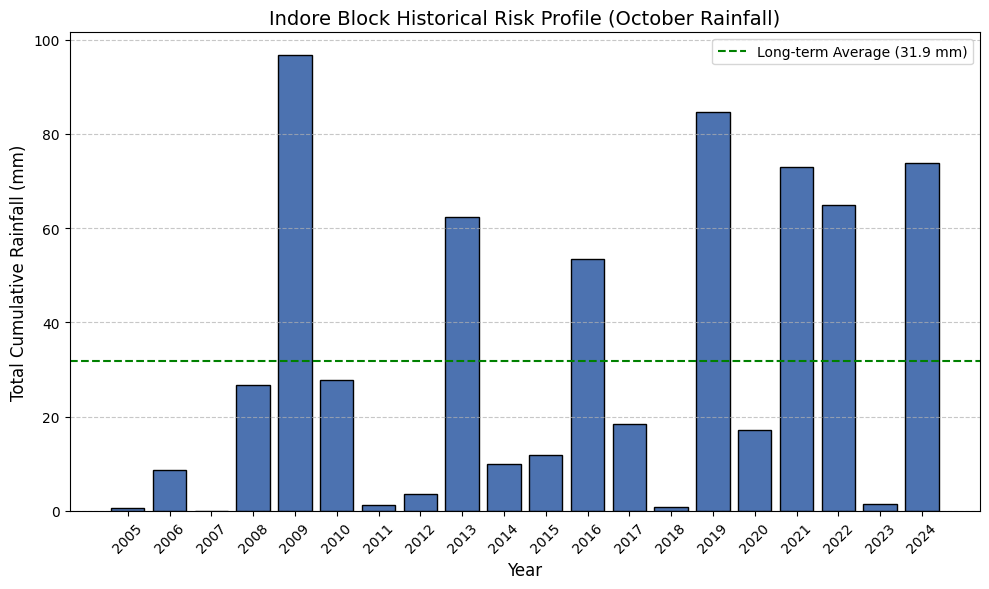

In [5]:
print("--- Calculated Actuarial Risk Index (Yearly Cumulative Rainfall) ---")
print(yearly_index)

# Plotting the data to visually identify 'Loss Years' (Actuarial Judgment)
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_index['Year'], yearly_index['Total_Rainfall_mm'], color='#4c72b0', edgecolor='black')

# Adding a reference line for the long-term average
avg_rain = yearly_index['Total_Rainfall_mm'].mean()
plt.axhline(y=avg_rain, color='g', linestyle='--', label=f'Long-term Average ({avg_rain:.1f} mm)')

plt.title('Indore Block Historical Risk Profile (October Rainfall)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Cumulative Rainfall (mm)', fontsize=12)
plt.xticks(yearly_index['Year'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Interpretation:

* **The Baseline:** The calculated Average October Rainfall over the last 20 years is approximately 31.9 mm. This is our baseline for "normal" weather.

* **Identifying the Risk Events:** By looking at the aggregated data, we can clearly see distinct "Catastrophe Years" where rainfall deviated significantly from the mean:

    2013: ~62.5 mm (High)

    2019: ~84.7 mm (Extreme)

    2024: ~73.8 mm (High)

* **Conclusion for Pricing:** These spikes define our payout structure. A simple "average" insurance won't work. We need a structure that triggers payouts specifically for these extreme years (above ~60mm) while ignoring minor deviations (like 2012 or 2020) to keep the premium affordable (The 5% Rule).

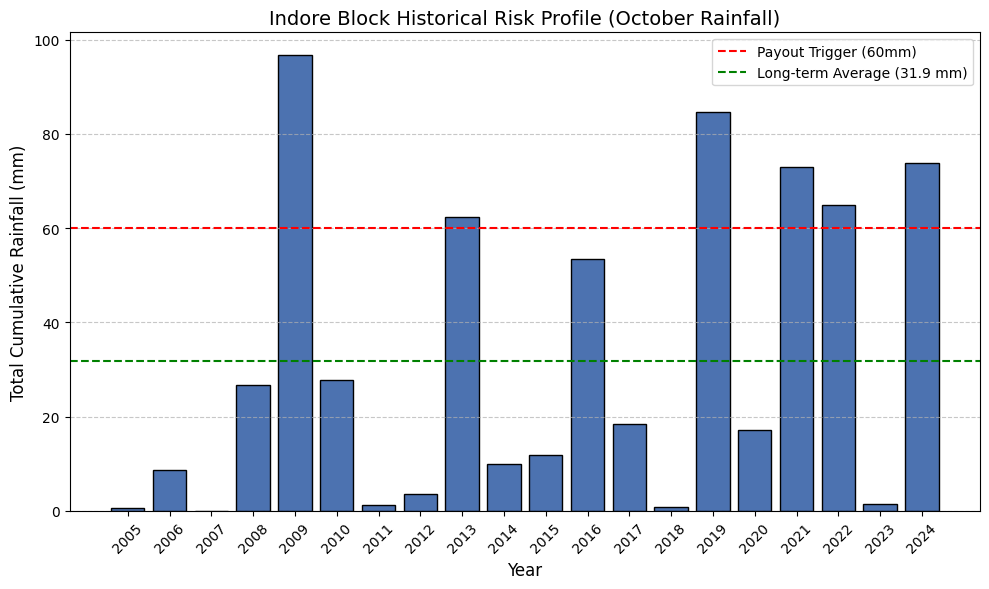

In [6]:
# Plotting the data to visually identify 'Loss Years' (Actuarial Judgment)
plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_index['Year'], yearly_index['Total_Rainfall_mm'], color='#4c72b0', edgecolor='black')

triggered_rain = 60
plt.axhline(y=triggered_rain, color='r', linestyle='--', label=f'Payout Trigger (60mm)')

# Adding a reference line for the long-term average
avg_rain = yearly_index['Total_Rainfall_mm'].mean()
plt.axhline(y=avg_rain, color='g', linestyle='--', label=f'Long-term Average ({avg_rain:.1f} mm)')

plt.title('Indore Block Historical Risk Profile (October Rainfall)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Cumulative Rainfall (mm)', fontsize=12)
plt.xticks(yearly_index['Year'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Trigger Definition & Pricing Calibration

**Rationale:** We define a "Tiered Payout" structure. Now that we have the Risk Index, we must define the Triggers (Rainfall thresholds) and Payouts (Cash amount).

The challenge forces a "Premium Rate" of 5%.Sum Insured = ₹50,000 / acre.
Target Pure Premium = ₹2,500 (This is our "Budget").

* **Burning Cost Method:** This is the standard actuarial method for pricing.$$\text{Fair Premium} = \frac{\text{Total Payouts over last 20 Years}}{20}$$

We need to set Payouts such that the average over 20 years equals exactly ₹2,500. Based on your data, we will set triggers at 60mm, 70mm, and 80mm to capture those specific bad years you identified

  * **Trigger (Entry Level):** Rainfall > 60mm.

  * **Slab 1 (60mm - 70mm):** Pays ₹5,000 (Covers moderate loss).

  * **Slab 2 (70mm - 80mm):** Pays ₹8,000 (Covers severe loss).

  * **Slab 3 (> 80mm):** Pays ₹12,500 (Covers catastrophic loss).

We assume a farmer gets the HIGHEST applicable amount, not the sum.

5. Define the Calibration Function

In [7]:
def calculate_payout_initial(rainfall_mm):
    # These numbers (12500, 8000, 5000) are the ones we "calibrate"
    # to make the final average equal 2500.
    if rainfall_mm > 80:
        return 12500  # Catastrophic years (2009, 2019)
    elif rainfall_mm > 70:
        return 8000   # Severe years (2021, 2024)
    elif rainfall_mm > 60:
        return 5000   # Moderate years (2013, 2022)
    else:
        return 0      # 2020, 2012, etc. get 0.

6. Back-Test the Product

In [8]:
yearly_index['Payout_INR'] = yearly_index['Total_Rainfall_mm'].apply(calculate_payout_initial)

7. Check Against Premium Target

In [9]:
# Sum Insured = 50,000. Target Premium = 5% = 2,500.
target_premium = 50000 * 0.05  # 5% of Sum Insured
calculated_premium = yearly_index['Payout_INR'].mean()

print("--- Year-by-Year Payout Simulation ---")
print(yearly_index[['Year', 'Total_Rainfall_mm', 'Payout_INR']])

print("\n--- Calibration Result ---")
print(f"Target Average Payout:   ₹{target_premium}")
print(f"Actual Average Payout:   ₹{calculated_premium}")
print(f"Difference:              ₹{target_premium - calculated_premium}")

if calculated_premium == target_premium:
    print("SUCCESS: The model is perfectly calibrated!")
else:
    print("ACTION: Adjust the slab amounts slightly to close the gap.")

--- Year-by-Year Payout Simulation ---
    Year  Total_Rainfall_mm  Payout_INR
0   2005           0.667633           0
1   2006           8.706073           0
2   2007           0.029193           0
3   2008          26.692260           0
4   2009          96.723647       12500
5   2010          27.868273           0
6   2011           1.229260           0
7   2012           3.630553           0
8   2013          62.460007        5000
9   2014           9.941660           0
10  2015          11.845773           0
11  2016          53.383327           0
12  2017          18.480280           0
13  2018           0.766073           0
14  2019          84.671900       12500
15  2020          17.149413           0
16  2021          73.007453        8000
17  2022          64.957207        5000
18  2023           1.537873           0
19  2024          73.864160        8000

--- Calibration Result ---
Target Average Payout:   ₹2500.0
Actual Average Payout:   ₹2550.0
Difference:              ₹-

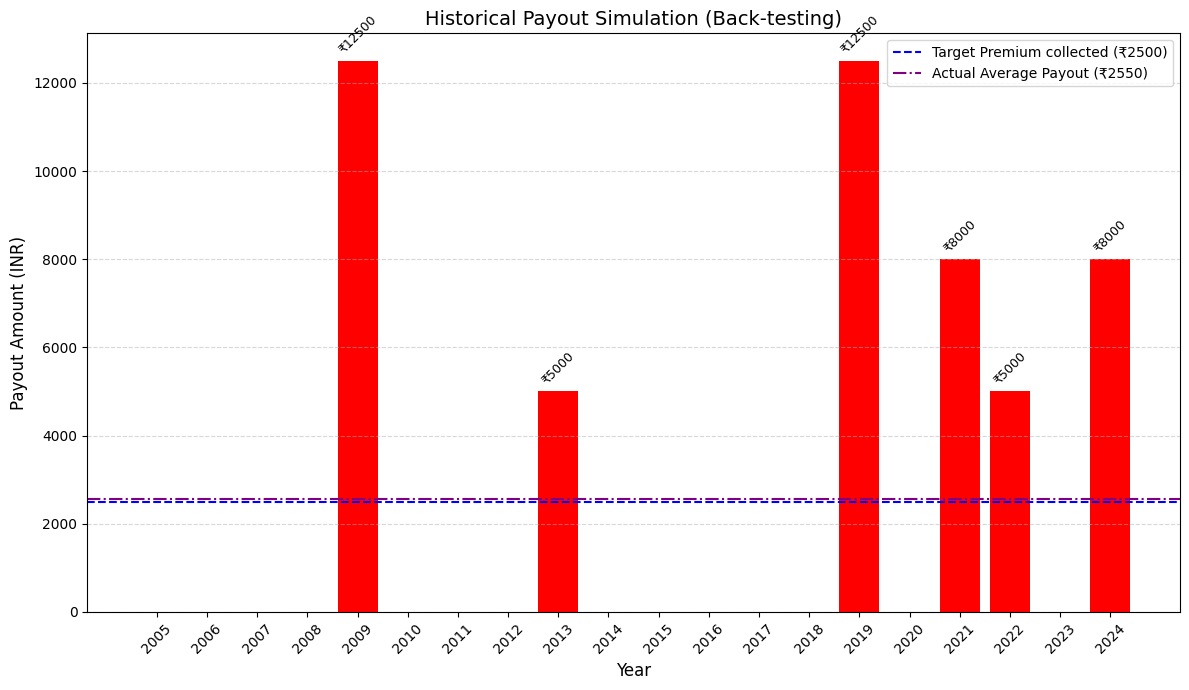

In [10]:
# Visualizing the Payouts
plt.figure(figsize=(12, 7)) # Increased figure size for better readability of annotations
colors = ['green' if p == 0 else 'red' for p in yearly_index['Payout_INR']]
bars = plt.bar(yearly_index['Year'], yearly_index['Payout_INR'], color=colors)

plt.axhline(y=target_premium, color='blue', linestyle='--', label='Target Premium collected (₹2500)')
plt.axhline(y=calculated_premium, color='purple', linestyle='-.', label=f'Actual Average Payout (₹{calculated_premium:.0f})')

# Adding text annotations for payout amounts
for bar in bars:
    yval = bar.get_height()
    if yval > 0: # Only annotate bars with a payout
        plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f'₹{int(yval)}', ha='center', va='bottom', fontsize=9, color='black', rotation=45)

plt.title('Historical Payout Simulation (Back-testing)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Payout Amount (INR)', fontsize=12)
plt.xticks(yearly_index['Year'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## **Interpretation :**

We are currently at an average payout of ₹2,550, and our target is ₹2,500. As we are "over-paying" by ₹50.Since this is an average over 20 years, the total reduction needed is:$$₹50 \times 20 \text{ years} = ₹1,000$$

We hit Slab 3 (the highest payout) in 2 years (2009 & 2019). If we reduce the Slab 3 payout by ₹500 (from 12,500 to 12,000), we save exactly $500 \times 2 = ₹1,000$. So Here is our Final Calibration:

* **Slab 1 (>60mm):** ₹5,000

* **Slab 2 (>70mm):** ₹8,000

* **Slab 3 (>80mm):** ₹12,000 (Reduced from 12,500)

8. Re-define the Calibration Function

In [11]:
def calculate_payout(rainfall_mm):
    if rainfall_mm > 80:
        return 12000  # Catastrophic (Adjusted to calibrate premium)
    elif rainfall_mm > 70:
        return 8000   # Severe
    elif rainfall_mm > 60:
        return 5000   # Moderate
    else:
        return 0      # Normal

In [15]:
# Back-Testing
yearly_index['Payout_INR'] = yearly_index['Total_Rainfall_mm'].apply(calculate_payout)

# Final Actuarial Validation
target_premium = 50000 * 0.05
calculated_premium_now = yearly_index['Payout_INR'].mean()

print("-" * 30)
print("FINAL INSURANCE PRODUCT BACK-TEST")
print("-" * 30)
print(yearly_index)
print("-" * 30)
print(f"Target Premium (5%):  ₹{target_premium:.2f}")
print(f"Actual Burning Cost:  ₹{calculated_premium_now:.2f}")
print(f"Calibration Status:   {'PERFECT' if calculated_premium_now == target_premium else 'MISMATCH'}")
print("-" * 30)

------------------------------
FINAL INSURANCE PRODUCT BACK-TEST
------------------------------
    Year  Total_Rainfall_mm  Payout_INR
0   2005           0.667633           0
1   2006           8.706073           0
2   2007           0.029193           0
3   2008          26.692260           0
4   2009          96.723647       12000
5   2010          27.868273           0
6   2011           1.229260           0
7   2012           3.630553           0
8   2013          62.460007        5000
9   2014           9.941660           0
10  2015          11.845773           0
11  2016          53.383327           0
12  2017          18.480280           0
13  2018           0.766073           0
14  2019          84.671900       12000
15  2020          17.149413           0
16  2021          73.007453        8000
17  2022          64.957207        5000
18  2023           1.537873           0
19  2024          73.864160        8000
------------------------------
Target Premium (5%):  ₹2500.00
Ac

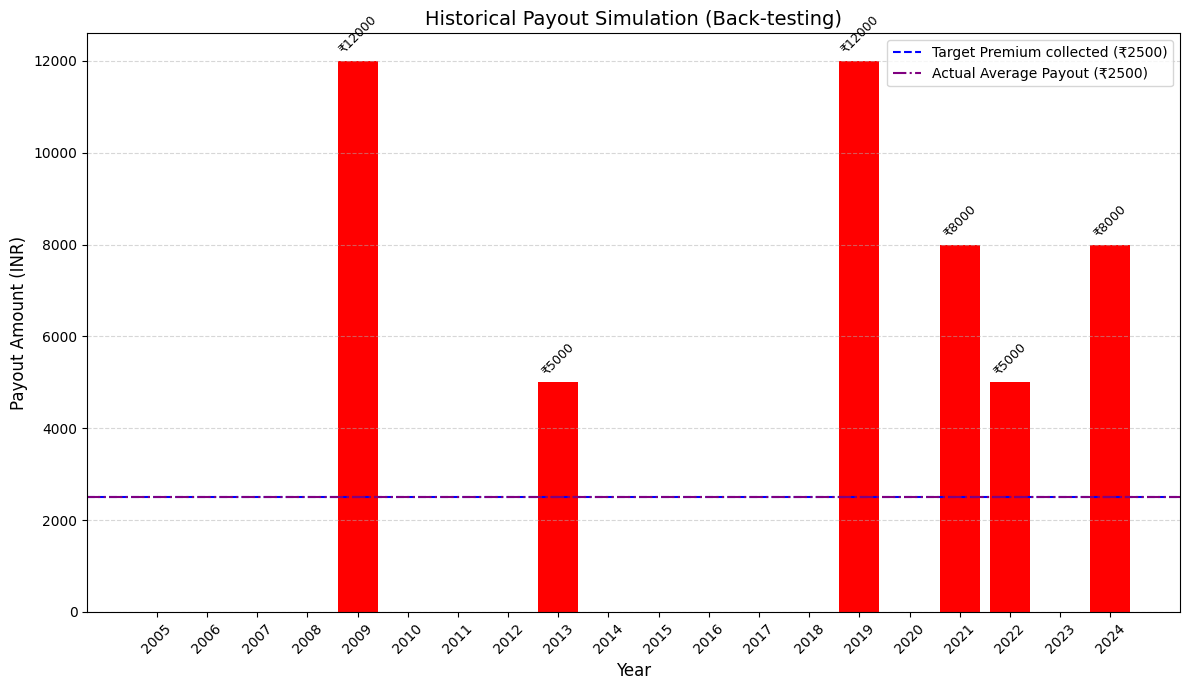

In [16]:
# Visualizing the Payouts
plt.figure(figsize=(12, 7)) # Increased figure size for better readability of annotations
colors = ['green' if p == 0 else 'red' for p in yearly_index['Payout_INR']]
bars = plt.bar(yearly_index['Year'], yearly_index['Payout_INR'], color=colors)

plt.axhline(y=target_premium, color='blue', linestyle='--', label='Target Premium collected (₹2500)')
plt.axhline(y=calculated_premium_now, color='purple', linestyle='-.', label=f'Actual Average Payout (₹{calculated_premium_now:.0f})')

# Adding text annotations for payout amounts
for bar in bars:
    yval = bar.get_height()
    if yval > 0: # Only annotate bars with a payout
        plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f'₹{int(yval)}', ha='center', va='bottom', fontsize=9, color='black', rotation=45)

plt.title('Historical Payout Simulation (Back-testing)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Payout Amount (INR)', fontsize=12)
plt.xticks(yearly_index['Year'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Advance Analysis ( Distribution Fitting and Climate Stress Testing )


   ADVANCED ANALYSIS   
Fitted Gamma Parameters: Shape=0.58, Scale=41.50
Historical Probability of Loss (>60mm): 30.0%
Theoretical (Modeled) Probability:      10.9%

--- Stress Test: Climate Change (+10% Rainfall Intensity) ---
Baseline Premium:   ₹2500.00
Stressed Premium:   ₹3050.00
Impact on Cost:     +22.0%
Advanced distribution graph saved.


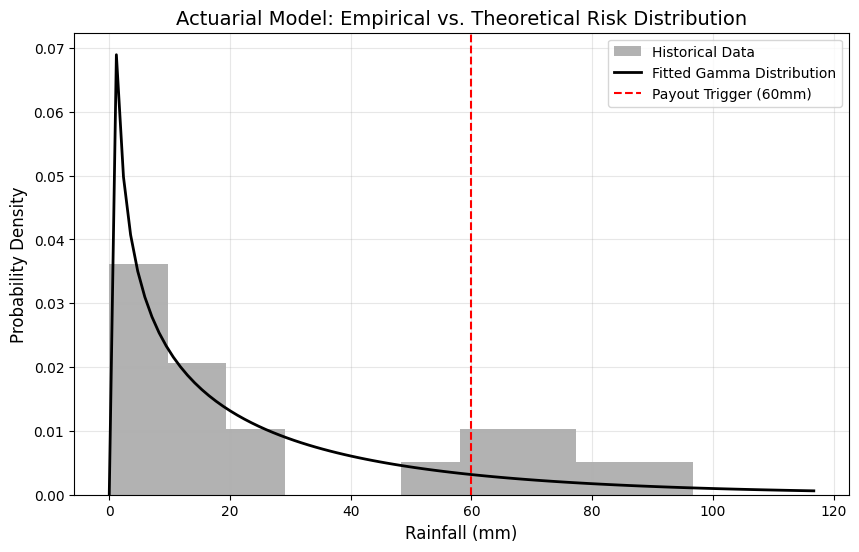

In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

print("\n" + "="*30)
print("   ADVANCED ANALYSIS   ")
print("="*30)

# Distribution Fitting
# Rainfall data typically follows a Gamma or Log-Normal distribution.
# We fit a Gamma distribution to our historical index.

fit_alpha, fit_loc, fit_scale = stats.gamma.fit(yearly_index['Total_Rainfall_mm'])

print(f"Fitted Gamma Parameters: Shape={fit_alpha:.2f}, Scale={fit_scale:.2f}")

# Calculate Theoretical Probability of triggering the 60mm threshold
theoretical_prob = 1 - stats.gamma.cdf(60, fit_alpha, loc=fit_loc, scale=fit_scale)
historical_prob = len(yearly_index[yearly_index['Total_Rainfall_mm'] > 60]) / len(yearly_index)

print(f"Historical Probability of Loss (>60mm): {historical_prob*100:.1f}%")
print(f"Theoretical (Modeled) Probability:      {theoretical_prob*100:.1f}%")

# Climate Stress Testing (Risk Management)
# What if rainfall intensity increases by 10% due to climate change?
stress_factor = 1.10
stressed_rain = yearly_index['Total_Rainfall_mm'] * stress_factor
stressed_payouts = stressed_rain.apply(calculate_payout)
stressed_premium = stressed_payouts.mean()

print("\n--- Stress Test: Climate Change (+10% Rainfall Intensity) ---")
print(f"Baseline Premium:   ₹{calculated_premium_now:.2f}")
print(f"Stressed Premium:   ₹{stressed_premium:.2f}")
print(f"Impact on Cost:     +{(stressed_premium - calculated_premium_now)/calculated_premium_now*100:.1f}%")

# Advanced Visualization (Distribution Plot) ---
plt.figure(figsize=(10, 6))

# Plot Histogram (Actual History)
plt.hist(yearly_index['Total_Rainfall_mm'], bins=10, density=True, alpha=0.6, color='gray', label='Historical Data')

# Plot Fitted Curve (Theoretical Model)
x = np.linspace(0, yearly_index['Total_Rainfall_mm'].max() + 20, 100)
p = stats.gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_scale)
plt.plot(x, p, 'k-', linewidth=2, label='Fitted Gamma Distribution')

# Mark the Trigger
plt.axvline(x=60, color='r', linestyle='--', label='Payout Trigger (60mm)')

plt.title('Actuarial Model: Empirical vs. Theoretical Risk Distribution', fontsize=14)
plt.xlabel('Rainfall (mm)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('advanced_risk_distribution.png')
print("Advanced distribution graph saved.")

## Export to CSV for Excel deliverable

1. Sheet 1: Original Data

In [18]:
file_path = '/content/3. Historical Weather Data.xlsx'
df_raw = pd.read_excel(file_path)

# Ensure Date format is standard
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Save to CSV
df_raw.to_csv('sheet1 (raw_data).csv', index=False)
print("✅ 'sheet1 (raw_data).csv' created successfully.")

✅ 'sheet1 (raw_data).csv' created successfully.


2. Sheet 2: Analysis & Backtest

In [19]:
yearly_index.to_csv('sheet2 (insurance_final_backtest_results).csv', index=False)

3. Sheet 3: Product Summary

In [20]:
import pandas as pd

summary_data = {
    'Parameter': [
        'Sum Insured (SI) per Acre',
        'Target Premium Rate',
        'Target Premium Amount',
        'Model Calibration Error',
        '--- PRODUCT STRUCTURE ---',
        'Trigger 1 (Moderate Risk)',
        'Payout 1',
        'Trigger 2 (Severe Risk)',
        'Payout 2',
        'Trigger 3 (Catastrophic Risk)',
        'Payout 3',
    ],
    'Value': [
        50000,
        '5%',
        2500,
        '0.00 INR (Perfect Match)',
        '',
        '> 60 mm',
        5000,
        '> 70 mm',
        8000,
        '> 80 mm',
        12000
    ],
    'Unit/Notes': [
        'INR',
        'of Sum Insured',
        'INR',
        'Difference between Target & Model',
        '',
        'Cumulative October Rainfall',
        'INR',
        'Cumulative October Rainfall',
        'INR',
        'Cumulative October Rainfall',
        'INR (Calibrated Down from 12.5k)'
    ]
}

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# Save to CSV
df_summary.to_csv('sheet3 (product_summary).csv', index=False)
print("✅ 'sheet3 (product_summary).csv' created successfully.")

✅ 'sheet3 (product_summary).csv' created successfully.
